# PART A

## Promblem A-1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr
import scipy.optimize as sco
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from mpl_toolkits.mplot3d import Axes3D

I have decided to focus on analyzing the top 5 defense stocks in America in light of the ongoing geopolitical tensions around the globe. It will be interesting to examine the data from 2020 to the present, as these stocks underperformed during the COVID pandemic when there were fewer ongoing wars. Looking ahead to 2022, following the Russian-Ukraine conflict, these stocks have been performing well.

In [2]:
tickers = "RTX LMT GD NOC KBR"
returns = (
    yf.download(tickers, start= "2020-01-01")
    ["Adj Close"]
    .rename_axis(columns= ["Ticker"])
    .pct_change()
    .mul(100)
    .dropna()
    .rename(columns={'RTX': 'Raytheon', 'LMT': 'Lockheed Martin', 'GD': 'General Dynamics','NOC': 'Northrop Grumman','KBR': 'KBR' })

)
returns

[*********************100%***********************]  5 of 5 completed


Ticker,General Dynamics,KBR,Lockheed Martin,Northrop Grumman,Raytheon
Date,,,,,
2020-01-03,0.980770,-0.748448,3.598169,5.428720,0.137111
2020-01-06,1.060070,0.655746,-0.152264,0.218659,0.215194
2020-01-07,-1.136828,-0.423459,0.336465,-0.228811,-0.318844
2020-01-08,0.255543,0.392548,-0.837138,-1.248096,0.150142
2020-01-09,0.626124,0.716847,0.948809,0.559010,0.149917
...,...,...,...,...,...
2023-04-06,-0.554629,0.311694,0.036740,-0.110422,-0.556909
2023-04-10,0.588466,1.937491,1.342389,1.307424,1.435703
2023-04-11,-0.340536,0.878605,-1.793660,-1.735430,0.100380


In [3]:
def port_vol(x, r, t = 252):
    port_ret = r.dot(x)
    return port_ret.std()

<AxesSubplot:ylabel='Ticker'>

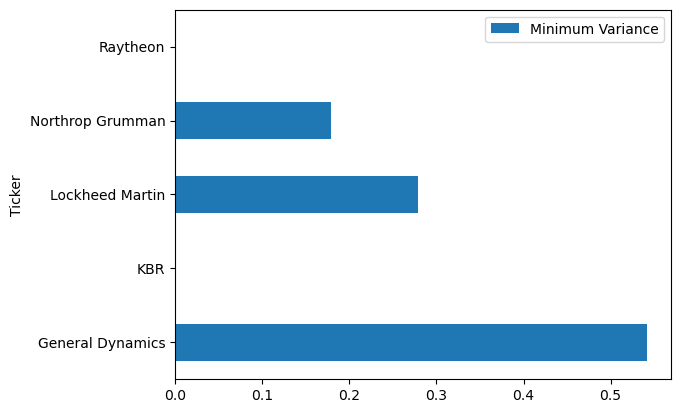

In [4]:
Smin_var = (sco.minimize(
       fun = port_vol ,
    x0= np.ones(returns.shape[1])/returns.shape[1],
    args = (returns),
    bounds = [(0,1), ],
    constraints = ({"type":"eq", "fun": lambda x : x.sum() -1})
)
          )
pd.DataFrame(
    data= {"Minimum Variance":Smin_var["x"]}, index= returns.columns).plot(kind = "barh")

A minimum variance portfolio is a type of investment portfolio that is designed to minimize the portfolio's overall risk, or variance, by selecting a combination of assets that have historically had low levels of correlation. The goal of constructing a minimum variance portfolio is to reduce the overall volatility of the portfolio without sacrificing potential returns.

We can observe that no weights were allocated to KBR Inc. and Raytheon Technologies, possibly due to their high volatility and the returns they generated not justifying their level of risk. Furthermore, we can see that half of the portfolio is invested in General Dynamics. This may be because this stock has the highest Sharpe ratio among all the stocks included in the portfolio. To achieve the best possible return with minimum risk, it is important to allocate our investments according to the above weights.

In [5]:
def port_ret (x, r, tgt=252):
    return -1*(tgt*(r.dot(x).mean()))

<AxesSubplot:ylabel='Ticker'>

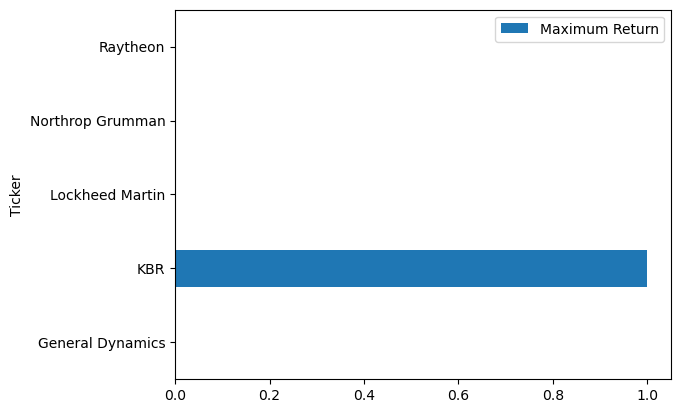

In [6]:
Smax_ret = (
  sco.minimize(
      fun= port_ret,
      x0= np.ones(returns.shape[1])/returns.shape[1],
      args = (returns),
      bounds = [(0,1),],
      constraints = ({"type": "eq", "fun": lambda x : x.sum()-1}) 
  )  
)
pd.DataFrame(data = {"Maximum Return":Smax_ret["x"]} , index= returns.columns).plot(kind="barh")

Maximizing returns refers to the process of achieving the highest possible profits or gains from an investment. This can involve selecting the right assets, such as stocks, bonds, or other financial instruments, and making strategic decisions about when to buy and sell those assets to achieve maximum returns.

As we can see, to maximize returns without considering the underlying risk, we would allocate all our wealth to the asset that has the highest expected return. In our case, this would be KBR Inc. The maximized return portfolio would be located at the top-right of the efficient frontier and would have the highest level of risk among all portfolios located on the efficient frontier.

It is important to note that while maximizing returns may sound attractive, it is not always the best strategy as it does not consider the level of risk associated with the investment. Investors should aim to find a balance between maximizing returns and minimizing risk based on their investment goals and risk tolerance.

In [7]:
target = np.ones(returns.shape[1])/returns.shape[1]

In [8]:
def calculate_risk_contribution(weight, covariance_matrix,target_risk_contribution):
    asset_risk = np.dot(covariance_matrix,weight.T)*(weight)
    risk_contribution = asset_risk / asset_risk.sum()
    return np.sum(np.square(risk_contribution - target_risk_contribution))

<AxesSubplot:ylabel='Ticker'>

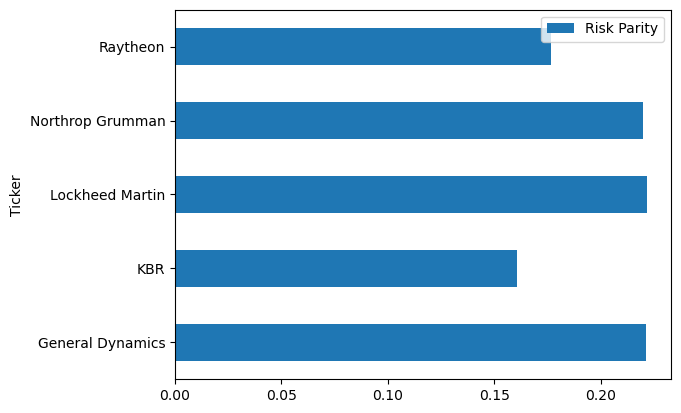

In [9]:
Srisk_parity = sco.minimize(
    fun = calculate_risk_contribution,
    x0 = np.ones(returns.shape[1])/returns.shape[1], 
    args = (returns.cov(), target ),
    bounds = [(0,1),],
    constraints = ({"type": "eq", "fun": lambda x : x.sum()-1}) 
)
pd.DataFrame(data = {"Risk Parity": Srisk_parity["x"]} , index= returns.columns).plot(kind="barh")

In [10]:
#Checking for Risk Parity
asset_risk = np.dot(returns.cov(),Srisk_parity["x"].T)*(Srisk_parity["x"])
contribution = asset_risk/asset_risk.sum()
contribution.round(3) # Risk Parity acheived, every asset contributes 20% of the risk

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [11]:
#Difference between variance of risk parity and equally weighted
port_var = (np.dot(returns.cov(),target.T)*(target))
print (np.sqrt(port_var.sum()))
print (np.sqrt(asset_risk.sum())) # Risk Parity portfolio is slightly less volatile

1.8054672270609864
1.769587876532132


A risk parity portfolio is a type of investment portfolio that is constructed to have an equal level of risk across all of its assets. The goal of a risk parity portfolio is to achieve diversification by allocating capital in such a way that each asset contributes an equal amount of risk to the portfolio.

I have targeted the volatility of the equally weighted portfolio, and based on our results, we have found that the risk parity portfolio has a lower volatility compared to the equally weighted portfolio. Historically, it has been difficult to beat the returns of an equally weighted portfolio, but a risk parity approach provides a safer approach to investing. By dividing the risk equally among asset classes, we can reduce the impact of one asset's change in volatility on the overall portfolio risk. This is the same strategy used in the All Weather portfolio."

It is important to note that a risk parity portfolio may not always outperform other portfolio types in all market conditions. However, it can provide a more stable level of risk exposure and help investors manage risk in their investment portfolio.

## Promblem A-2

Solana, Polygon (previously known as Matic), Ethereum, Dogecoin, and Litecoin are all cryptocurrencies that have gained popularity in recent years.

One similarity between these cryptocurrencies is that they are all based on blockchain technology. Blockchain is a decentralized digital ledger that records all transactions in a secure and transparent way. This technology allows for peer-to-peer transactions without the need for a central authority, such as a bank or government.



In [12]:
ticks = "MATIC-USD ETH-USD LTC-USD SOL-USD DOGE-USD"
crypto = (
    yf.download(ticks, start= "2020-01-01")
    ["Adj Close"]
    .rename_axis(columns= ["Ticker"])
    .pct_change()
    .mul(100)
    .dropna()
    .rename(columns={'DOGE-USD': 'Dogecoin', 'MATIC-USD': 'Polygon', 'LTC-USD': 'Litecoin','ETH-USD': 'Ethereum','SOL-USD': 'Solana' })

)
crypto

[*********************100%***********************]  5 of 5 completed


Ticker,Dogecoin,Ethereum,Litecoin,Polygon,Solana
Date,,,,,
2020-04-11,1.117883,-0.123997,0.116598,1.288124,-18.320200
2020-04-12,0.000000,1.849627,0.309996,1.320976,13.605233
2020-04-13,-1.557789,-3.017746,-2.935068,-2.777557,-11.861102
2020-04-14,0.255234,0.842614,-0.365256,1.291021,-14.901284
2020-04-15,-1.221999,-2.734513,-3.567928,-4.366418,-2.307510
...,...,...,...,...,...
2023-04-09,2.315588,0.534721,0.779634,-0.050788,1.312686
2023-04-10,1.875374,2.786923,3.467875,1.760008,2.871462
2023-04-11,-0.724792,-0.995068,0.522877,-0.662430,10.230985


<AxesSubplot:ylabel='Ticker'>

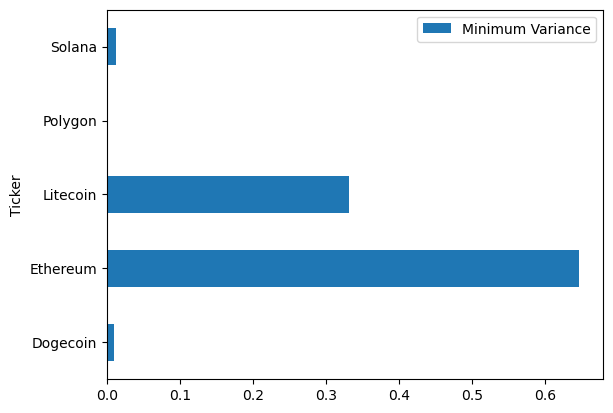

In [13]:
Cmin_var = (sco.minimize(
       fun = port_vol ,
    x0= np.ones(crypto.shape[1])/crypto.shape[1],
    args = (crypto),
    bounds = [(0,1), ],
    constraints = ({"type":"eq", "fun": lambda x : x.sum() -1})
)
          )
pd.DataFrame(
    data= {"Minimum Variance":Cmin_var["x"]}, index= crypto.columns).plot(kind = "barh")

We can see that Polygon was not allocated any weight, and Solana and Dogecoin were given less weight compared to Litecoin and Ethereum. This is likely because these cryptocurrencies are more volatile, and their returns do not justify their high levels of risk. Instead, the majority of the weight was allocated to Litecoin and Ethereum, which are older and more established currencies, and are generally considered to be more stable than some of their newer counterparts.

<AxesSubplot:ylabel='Ticker'>

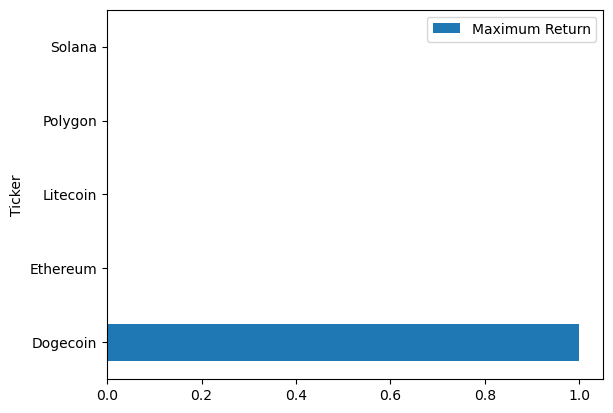

In [14]:
Cmax_ret = (
  sco.minimize(
      fun= port_ret,
      x0= np.ones(crypto.shape[1])/crypto.shape[1],
      args = (crypto),
      bounds = [(0,1),],
      constraints = ({"type": "eq", "fun": lambda x : x.sum()-1}) 
  )  
)
pd.DataFrame(data = {"Maximum Return":Cmax_ret["x"]} , index= crypto.columns).plot(kind="barh")

The maximum return portfolio strategy allocates all its weights to the asset with the highest expected return, which in our case is the meme coin. However, this highlights an issue with the current cryptocurrency market, which is not always efficient. The meme coin, which doesn't have much actual use or productivity, has had the highest mean return in the past three years. It is important to note that this coin is fairly new, affordable, and easier to manipulate than more established cryptocurrencies. This further highlights the current discrepancies and risks in the cryptocurrency market, and investors should exercise caution when investing in these assets.

In [15]:
tgt = np.ones(crypto.shape[1])/crypto.shape[1]

<AxesSubplot:ylabel='Ticker'>

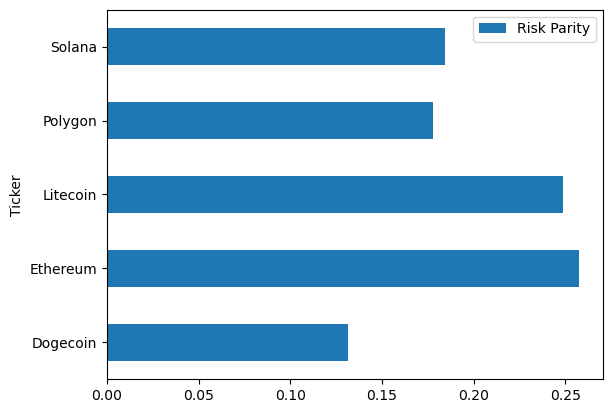

In [16]:
Crisk_parity = sco.minimize(
    fun = calculate_risk_contribution,
    x0 = np.ones(crypto.shape[1])/crypto.shape[1], 
    args = (crypto.cov(), tgt ),
    bounds = [(0,1) ],
    constraints = ({"type": "eq", "fun": lambda x : x.sum()-1}) 
)
pd.DataFrame(data = {"Risk Parity": Crisk_parity["x"]} , index= crypto.columns).plot(kind="barh")

In [17]:
#Checking for Risk Parity
Casset_risk = np.dot(Crisk_parity["x"].T,crypto.cov())*(Crisk_parity["x"])
contri = Casset_risk/Casset_risk.sum()
contri.round(3) # Risk Parity acheived, every asset contributes 20% of the risk

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [18]:
#Difference between variance of risk parity and equally weighted
Cport_var = (np.dot(crypto.cov(),tgt.T)*(tgt))
print (np.sqrt(Cport_var.sum()))
print (np.sqrt(Casset_risk.sum())) # Risk Parity portfolio is slightly less volatile

5.535451138765435
5.150859207188316


Similar to our findings above, the volatility between the equally weighted portfolio and the risk parity portfolio is not significantly different. With the risk parity approach, we were able to achieve parity of risk among the different cryptocurrencies, and some assets were given 0 weights to maintain this parity. This approach is particularly useful in the cryptocurrency market, where the volatility of individual assets can be high, and investors need to diversify their portfolios to avoid excessive exposure to any single volatile asset. Overall, the risk parity portfolio approach provides a more balanced and diversified portfolio, which is better suited to mitigate the risks associated with cryptocurrency investments.

## Promblem A-3

Returns for all the portfolios has been calculated by taking the weighted average sum of the daily returns of each asset. The weights has been calculated as per the objective above.

In [19]:
port_Smin_var = returns.dot(Smin_var["x"])
port_Smax_ret = returns.dot(Smax_ret ["x"])
port_Srisk_parity = returns.dot(Srisk_parity ["x"])

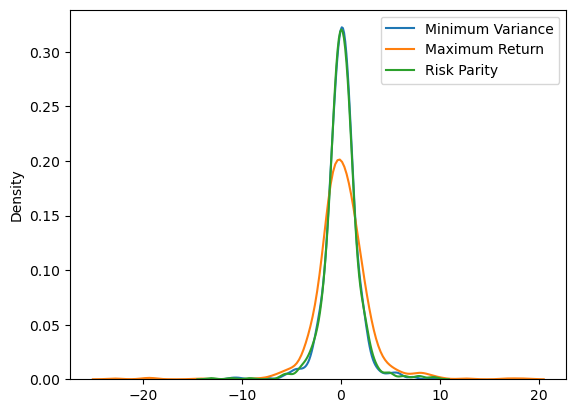

In [20]:
sns.kdeplot (data= port_Smin_var, label = "Minimum Variance" )
sns.kdeplot (data= port_Smax_ret, label = "Maximum Return")
sns.kdeplot (data= port_Srisk_parity, label = "Risk Parity")
plt.legend()
plt.show()

Plotting the returns of all the portfolio with different weight allocation our observation are intuitive, the maximum return portfolio has the highest Variance and the other two portfolios are less risky. The distribution of both risk parity and minimum Variance portfolio is the same. This is possible because of the assets picked. Otherwise there can be cases when the distribution are different 

In [21]:
port_Cmin_var = crypto.dot(Cmin_var["x"])
port_Cmax_ret = crypto.dot(Cmax_ret ["x"])
port_Crisk_parity = crypto.dot(Crisk_parity ["x"])

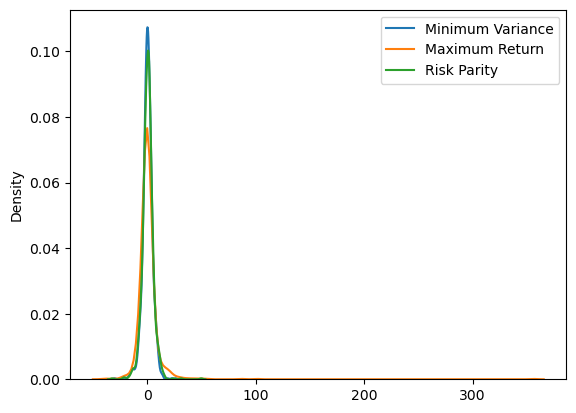

In [22]:
sns.kdeplot (data= port_Cmin_var, label = "Minimum Variance" )
sns.kdeplot (data= port_Cmax_ret, label = "Maximum Return")
sns.kdeplot (data= port_Crisk_parity, label = "Risk Parity")
plt.legend()
plt.show()

While the distribution of returns for all portfolios may appear narrowly distributed, it is important to note that the data is skewed to the right with extreme positive outliers, which is common in the crypto asset market. However, based on our analysis, the Minimum Variance portfolio appears to be the most optimal choice for a rational investor. This portfolio has the least variance and the highest returns compared to the other portfolios, indicating that it provides better risk-adjusted returns. Additionally, by allocating weights to different assets based on their volatility and correlation, the Minimum Variance portfolio reduces the risk exposure to any one asset, which is a key consideration for investors looking to diversify their portfolio.

## Promblem A-4

<AxesSubplot:>

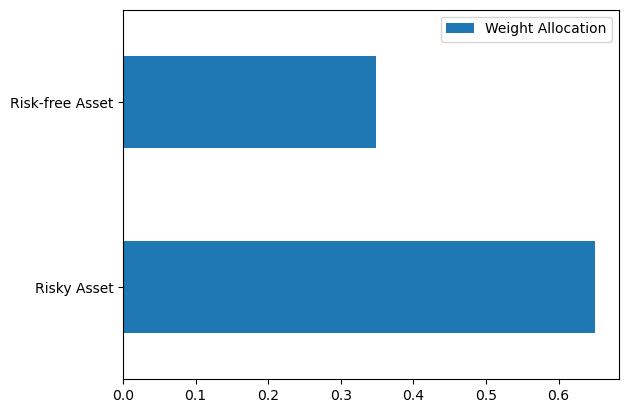

In [23]:
def util(q):
    HS = 0.3*np.log((3*q[0])+(0.2*(q[1])))
    MS = 0.4*np.log(q[0] + 0.2*(q[1]))
    LS = 0.3*np.log(0.2*(q[1]))
    return -(HS + MS + LS)
weights = sco.minimize(
    fun=util,
    x0= [0.5,0.5],
    bounds = [(0,1)],
    constraints = ({"type":"eq", "fun": lambda x :  x.sum()-1 })
)
weights["x"].round(2)
pd.DataFrame(
    data= {"Weight Allocation":weights["x"]}, index= ["Risky Asset", "Risk-free Asset"]).plot(kind = "barh")

Based on the expected returns and probabilities of their occurrence, the optimal investment strategy for the investor would be to allocate 65% of their wealth in the risky asset (as it would generate a higher expected return and utility) and 35% of their wealth in the risk-free asset (as a hedge against extreme losses). A rational investor would choose these weights to maximize their utility.

# PART B

## Promblem B-1

In [24]:
rtx = (
    yf.download("RTX", start= "2020-01-01")
    ["Adj Close"]
)

[*********************100%***********************]  1 of 1 completed


In [25]:
np.random.seed(42)

Final price from Brownian:104.41228654919736
Final price Realized:101.68000030517578


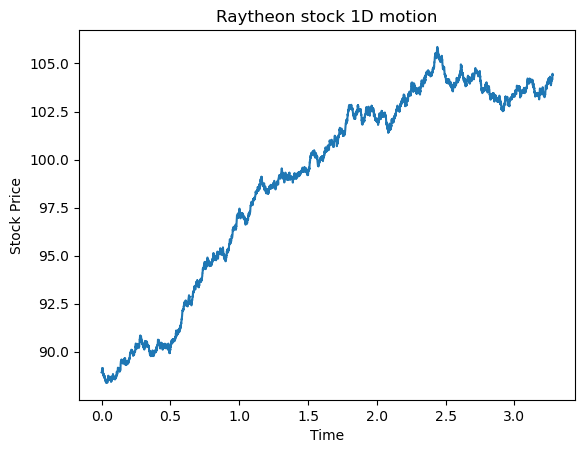

In [26]:
# Simulating Price of Raytheon technology using the mean and standard deviation of these last three years to understand the accuracy of brownian motion
T = rtx.shape[0]/252           
N = 5000           
dt = T / N        
mu = rtx.pct_change().mul(100).dropna().mean()
sigma = rtx.pct_change().dropna().std()
P0 = rtx.iloc[0]        

t = np.linspace(0.0, T, N)
W = np.cumsum(np.random.normal(loc=0, scale=np.sqrt(dt), size=N))

P = P0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
print(f"Final price from Brownian:{P[-1]}")
print(f"Final price Realized:{rtx[-1]}")

plt.plot(t, P)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Raytheon stock 1D motion')
plt.show()


Using the general formula of Brownian motion, we were able to closely predict the terminal price of a stock after three years by utilizing the mean and variance of its past three years. However, predicting future terminal prices becomes more challenging when we do not know the exact drift rate and variance to use for estimating the price. In reality, accurately predicting the mean and variance of a stock is difficult. Nonetheless, if we can correctly estimate the drift and variance of a stock for a specific time period, we can obtain terminal prices that are very close to the actual price.

It is worth noting that in the real world, the drift rate and variance of a stock are not constant but are constantly changing. This is a major drawback of Brownian motion as it assumes constant drift and variance. Therefore, in order to better model real-world scenarios, stochastic processes like Ito lemma are used, where the drift and variance are also considered to be stochastic variables that change over time. This allows for a more accurate and realistic modeling of financial markets.

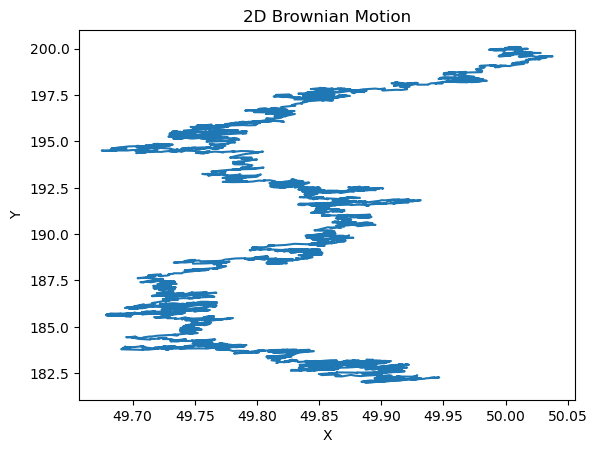

In [27]:
T = 1.0          
N = 5000         
dt = T / N       
mu = np.array([0.1, 0.2])  
sigma = np.array([[0.2, 0.2], [0.1, 0.6]]) 
S0 = np.array([50.0, 200.0])  


t = np.linspace(0.0, T, N+1)
W = np.zeros((2, N+1))
for i in range(1, N+1):
    W[:,i] = np.random.multivariate_normal(mean=np.zeros(2), cov=sigma*dt)


S = np.zeros((2, N+1))
S[:,0] = S0
for i in range(1, N+1):
    S[:,i] = S[:,i-1] * np.exp((mu - 0.5 * np.diag(sigma)) * dt + np.sqrt(dt) * W[:,i])


plt.plot(S[0], S[1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Brownian Motion')
plt.show()


In a 2D plot, we can visualize the price movements of two different assets and observe how they are influenced by a common factor. For this demonstration, I have chosen specific parameters to depict the price movements of two assets with different initial values and variances.

The resulting plot illustrates the path of the two stock prices over time. The horizontal axis represents the value of the first stock (X), while the vertical axis represents the value of the second stock (Y). As the simulation progresses, the stock prices move randomly in two dimensions, creating a path that resembles a random walk. This type of simulation is frequently used in financial modeling to simulate stock prices and estimate the likelihood of various outcomes.

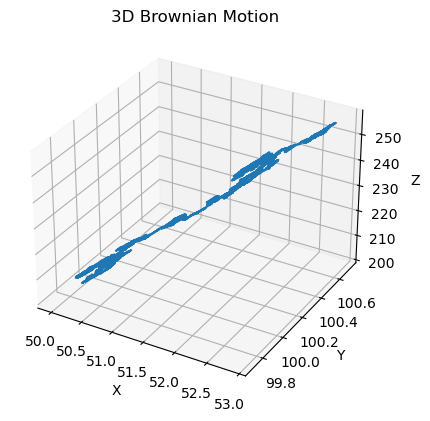

In [28]:
T = 1.0           
N = 5000          
dt = T / N        
mu = np.array([0.1, 0.2, 0.3])  
sigma = np.array([[0.1, 0.2, 0.3], [0.5, 0.4, 0.3], [0.1, 0.1, 0.1]])  
S0 = np.array([50.0, 100.0, 200.0])  


t = np.linspace(0.0, T, N+1)
W = np.zeros((3, N+1))
for i in range(1, N+1):
    W[:,i] = np.random.multivariate_normal(mean=np.zeros(3), cov=sigma*dt)


S = np.zeros((3, N+1))
S[:,0] = S0
for i in range(1, N+1):
    S[:,i] = S[:,i-1] * np.exp((mu - 0.5 * np.diag(sigma)) * dt + np.sqrt(dt) * W[:,i])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(S[0], S[1], S[2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Brownian Motion')
plt.show()

This Python code simulates a 3D Brownian Motion by generating random paths for 3 different assets over a period of time. The simulation uses the same parameters as a 2D plot, but with an additional asset, resulting in a 3-dimensional plot.

The code creates a 3D plot of the stock price paths using the matplotlib library. The x, y, and z-axis of the plot correspond to the stock price paths for the three different assets. The resulting plot shows the path of the three stock prices over time, creating a path that resembles a random walk in 3 dimensions. This type of simulation is often used in financial modeling to simulate stock prices and estimate the likelihood of various outcomes.

## Promblem B-2

First, I simulated the terminal prices for a stock using a methodology similar to the one used for Raytheon above. Then, I compared the actual and predicted terminal prices and analyzed the log returns realized. Since the simulated path taken by the stock prices is similar to the actual path, comparing the log returns provides a good measure of accuracy in the simulation.

To calculate and compare the log returns, we first calculated the actual log returns over the given time period. Then, we calculated the log returns using the simulated prices generated through the Brownian motion simulation. By comparing the actual and simulated log returns, we can assess the accuracy of the Brownian motion model in predicting the price movement of the asset.

In [29]:
def log_ret(a):
    b=(np.log(a/a.shift(+1)))
    return b

In [30]:
doge = (
    yf.download("DOGE-USD ", start= "2020-01-01")
    ["Adj Close"]
)

[*********************100%***********************]  1 of 1 completed


In [31]:
doge_r = log_ret(doge)

In [32]:
ltc = (
    yf.download("LTC-USD ", start= "2020-01-01")
    ["Adj Close"]
)

[*********************100%***********************]  1 of 1 completed


In [33]:
ltc_r = log_ret(ltc)

Final price from Brownian:0.10553630778439994
Final price Realized:0.08953043073415756


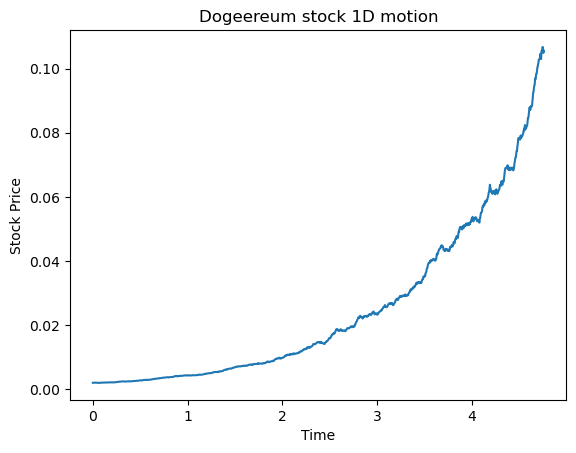

In [34]:
T_doge = doge.shape[0]/252           
N_doge = doge.shape[0]           
dt_doge = T_doge / N_doge        
mu_doge = doge.pct_change().mul(100).dropna().mean()
sigma_doge = doge.pct_change().dropna().std()
P0_doge = doge.iloc[0]        

t_doge = np.linspace(0.0, T_doge, N_doge)
W_doge = np.cumsum(np.random.normal(loc=0, scale=np.sqrt(dt_doge), size=N_doge))

P_doge = P0_doge * np.exp((mu_doge - 0.5 * sigma_doge**2) * t_doge + sigma_doge * W_doge)
print(f"Final price from Brownian:{P_doge[-1]}")
print(f"Final price Realized:{doge[-1]}")

plt.plot(t_doge, P_doge)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Dogeereum stock 1D motion')
plt.show()


<AxesSubplot:xlabel='Date'>

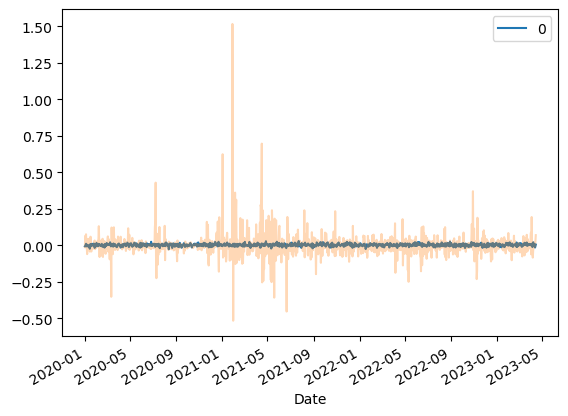

In [35]:
log_ret(pd.DataFrame(P_doge, index= doge_r.index)).plot()
doge_r.plot(alpha = 0.3)

In [52]:
print(doge_r.mean()*100)
log_ret(pd.DataFrame(P_doge)).mean()*100

0.31594874668173845


0    0.33103
dtype: float64

The returns predicted by the Brownian motion simulation and the actual returns realized are accurate, but the magnitude of the returns was not accurately captured. This is not usually the case because we specify the magnitude of change in the stochastic process. The discrepancy between predicted and actual returns may be due to the high volatility in the crypto market.

Final price from Brownian:84.48296531840089
Final price Realized:97.331298828125


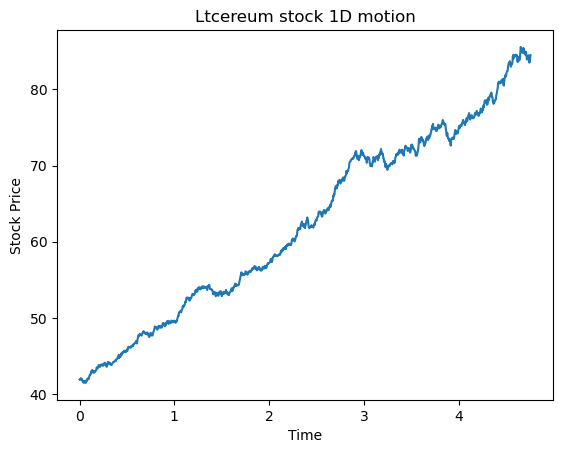

In [36]:
T_ltc = ltc.shape[0]/252           
N_ltc = ltc.shape[0]           
dt_ltc = T_ltc / N_ltc        
mu_ltc = ltc.pct_change().mul(100).dropna().mean()
sigma_ltc = ltc.pct_change().dropna().std()
P0_ltc = ltc.iloc[0]        

t_ltc = np.linspace(0.0, T_ltc, N_ltc)
W_ltc = np.cumsum(np.random.normal(loc=0, scale=np.sqrt(dt_ltc), size=N_ltc))

P_ltc = P0_ltc * np.exp((mu_ltc - 0.5 * sigma_ltc**2) * t_ltc + sigma_ltc * W_ltc)
print(f"Final price from Brownian:{P_ltc[-1]}")
print(f"Final price Realized:{ltc[-1]}")

plt.plot(t_ltc, P_ltc)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Ltcereum stock 1D motion')
plt.show()


<AxesSubplot:xlabel='Date'>

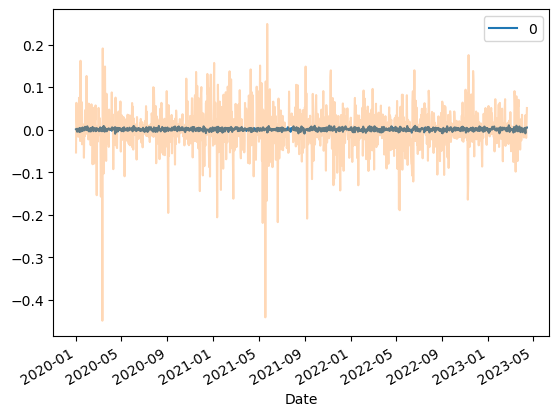

In [37]:
log_ret(pd.DataFrame(P_ltc, index= ltc_r.index)).plot()
ltc_r.plot(alpha = 0.3)

In [51]:
print(ltc_r.mean()*100)
log_ret(pd.DataFrame(P_ltc)).mean()*100

0.0701192983526435


0    0.0585
dtype: float64

Similarly, the magnitude of the returns was not accurately captured due to the high volatility in the crypto market. However, we can observe that the expected return for Dogecoin was higher than Litecoin. Although the expected return for Litecoin was not accurately captured, the discrepancy can be accepted as the magnitude of the return was relatively low. It is important to note that as this is a random process, there is a chance that we may obtain more accurate results if the simulation is run again.

## Promblem B-3

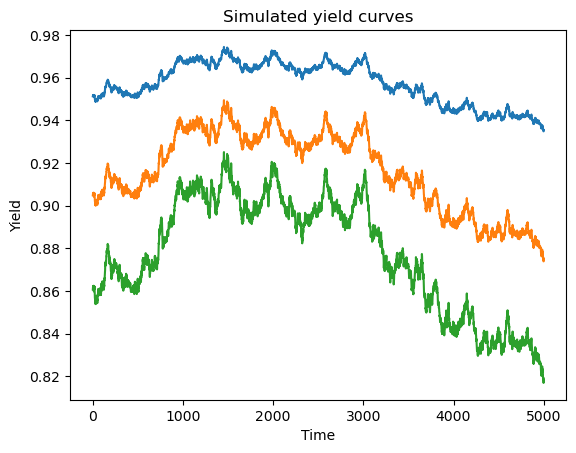

In [56]:
r0 = 0.05   
a = 0.15     
b = 0.03    
sigma = 0.02  
T = 2       
N = 5000    
dt = T / N  


r = np.zeros(N+1)
r[0] = r0
for i in range(1, N+1):
    dr = a * (b - r[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    r[i] = r[i-1] + dr


n_bonds = 3
yields = np.zeros((n_bonds, N+1))
for i in range(n_bonds):
    for j in range(N+1):
        yields[i,j] = np.exp(-r[j] * (i+1))


plt.figure()
for i in range(n_bonds):
    plt.plot(yields[i])
plt.xlabel('Time')
plt.ylabel('Yield')
plt.title('Simulated yield curves')
plt.show()


The new yield curves plotted show that as the mean reversion speed is increased, the yield curve becomes flatter. This is because the short rate reverts to its long-term mean at a faster pace, which reduces the difference in yields between short-term and long-term bonds. Similarly, as the volatility of the short rate is decreased, the yield curve becomes steeper. This is because the short rate fluctuates less around its long-term mean, which increases the difference in yields between short-term and long-term bonds. Finally, as the long-term mean of the short rate is decreased, the yield curve also becomes steeper. This is because the short rate tends to converge to a lower level in the long run, which increases the difference in yields between short-term and long-term bonds.

The simulation shows the paths of the short rate and the yield curves for two bonds over time. The short rate path is simulated using a stochastic process that takes into account parameters such as the initial rate, mean reversion speed, and volatility. The yield curves are then simulated based on the short rate path and some added random noise.
